In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('.')

In [2]:
from argparse import Namespace
import pickle

import pyro
from pyro import distributions as dist
import torch
from torch.distributions import constraints

from src.pgm import utils

pyro.enable_validation(True)

![](https://miro.medium.com/max/1400/0*Ws_1F7ZFdbqph4Y8.)

$$\mathbb{P}(\texttt{Difficulty} = d) \sim \texttt{Bernoulli}(\theta^D),\; d \in \{0, 1\}$$

$$\mathbb{P}(\texttt{Intelligence} = i) \sim  \texttt{Bernoulli}(\theta^I),\; i \in \{0, 1\}$$

$$\mathbb{P}(\texttt{Grade} = g\; |\; \texttt{Difficulty} = d, \texttt{Intelligence} = i) \sim \texttt{Cat}(\theta^G_{d, i}),\; g \in \{0, 1, 2\}$$

$$\mathbb{P}(\texttt{SAT} = s\; |\; \texttt{Intelligence} = i) \sim \texttt{Bernoulli}(\theta^S_i),\; s \in \{0, 1\}$$

$$\mathbb{P}(\texttt{Letter} = l \;|\; \texttt{Grade} = g) \sim \texttt{Bernoulli}(\theta^L_g),\; l \in \{0, 1\}$$

# Homework (part 3)

## Prepare model and guide
- Implement the above given model.
- Select initial parameter values $\theta$, so that each outcome is equally probable.

In [15]:
pyro.clear_param_store()

def model(x):
    d_prob = pyro.param('theta_D', torch.tensor([0.5])  ,constraint=constraints.unit_interval)
    i_prob = pyro.param('theta_I', torch.tensor([0.5])  ,constraint=constraints.unit_interval)
    g_prob = pyro.param('theta_G', torch.ones((2,2,3))*1/3,constraint=constraints.simplex)
    l_prob = pyro.param('theta_L', torch.ones(3) * 1/3  ,constraint=constraints.unit_interval)
    s_prob = pyro.param('theta_S', torch.ones(2)*1/2    ,constraint=constraints.unit_interval)
  
    with pyro.plate('data' , x.shape[0]):
        d = pyro.sample('d', dist.Bernoulli(d_prob),        obs=x.d)
        i = pyro.sample('i', dist.Bernoulli(i_prob),        obs=x.i)
        g = pyro.sample('g', dist.Categorical(g_prob[d.long(),i.long()]), obs=x.g)
        l = pyro.sample('l', dist.Bernoulli(l_prob[g.long()]),     obs=x.l)
        s = pyro.sample('s', dist.Bernoulli(s_prob[i.long()]),     obs=x.s)

def guide(x):
    pass

## Read data
Columns:
- Difficulty
- Intelligence
- SAT
- Grade
- Letter

In [16]:
with open('data/pgm-student-data.pkl', 'rb') as fin:
    full_data = torch.tensor(pickle.load(fin), dtype=torch.float)

Loss = 1958.8081359863281
Loss = 1684.8238830566406
Loss = 1558.9893035888672
Loss = 1495.9999694824219
Loss = 1460.956298828125
Loss = 1440.1444244384766
Loss = 1427.2685546875
Loss = 1419.0625457763672
Loss = 1413.7145080566406
Loss = 1410.1702728271484
Loss = 1407.7891540527344
Loss = 1406.1722412109375
Loss = 1405.0624542236328
Loss = 1404.2941284179688
Loss = 1403.7559814453125
Loss = 1403.3757934570312
Loss = 1403.1037902832031
Loss = 1402.9070892333984
Loss = 1402.762451171875
Loss = 1402.6552276611328



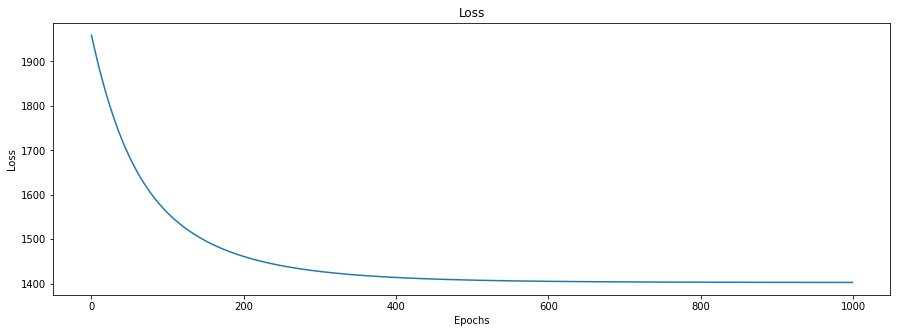

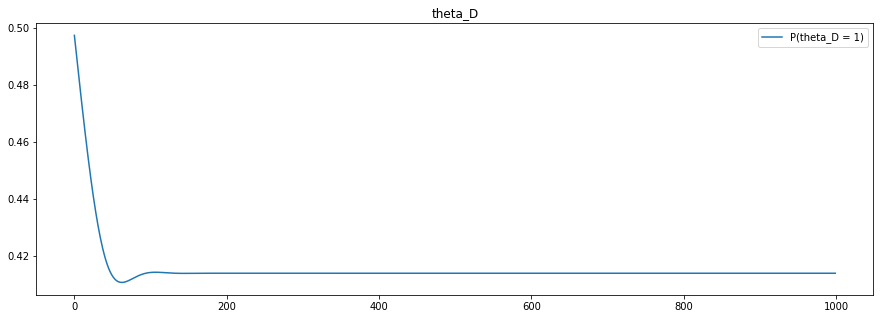

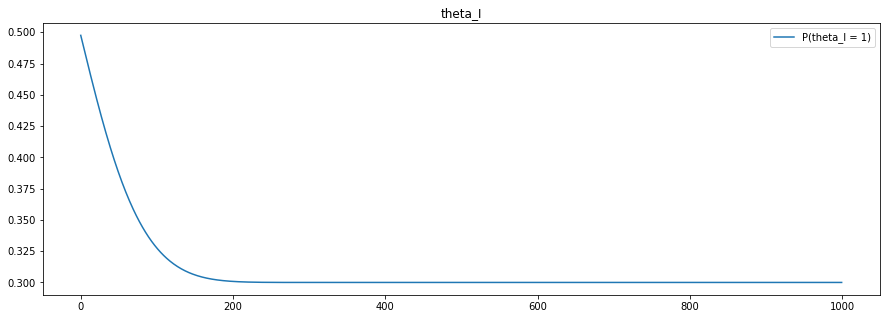

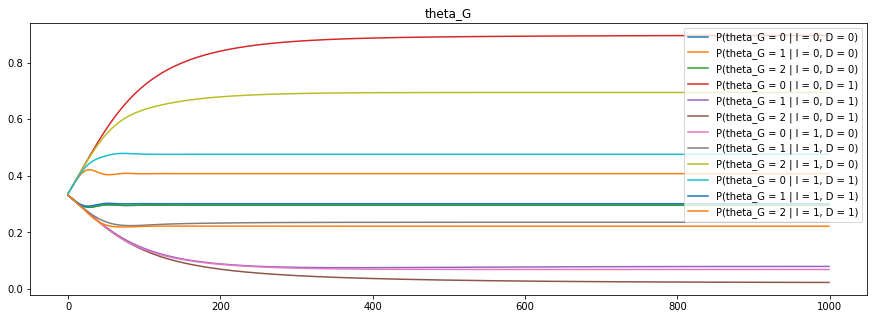

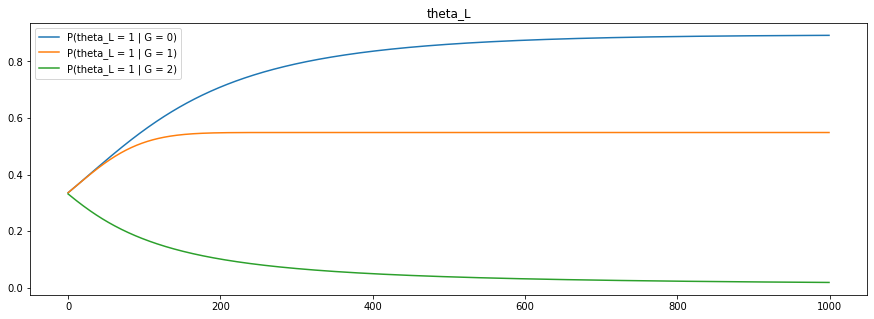

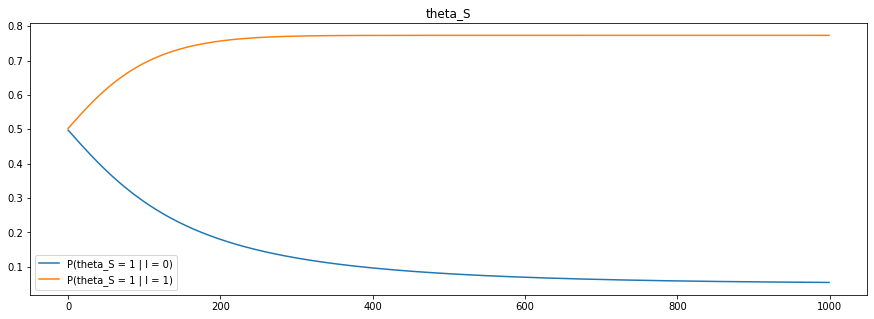

In [17]:
x = Namespace(
    d=full_data[:, 0],
    i=full_data[:, 1],
    
    s=full_data[:, 2],
    g=full_data[:, 3],
    
    l=full_data[:, 4],
    
    shape=full_data.shape,
)

hist = utils.train_svi(model=model, guide=guide, X=x, num_epochs=1_000, lr=1e-2)

utils.visualize_nb_parameters(hist)

In [18]:
for pname, pval in dict(pyro.get_param_store()).items():
    print(pname, pval.detach().numpy())

theta_D [0.41399997]
theta_I [0.29999998]
theta_G [[[0.2961165  0.40776697 0.2961165 ]
  [0.8961368  0.08023369 0.02362951]]

 [[0.06944451 0.23611104 0.6944445 ]
  [0.47619045 0.3015873  0.22222225]]]
theta_L [0.8924648  0.5486111  0.01796973]
theta_S [0.05402604 0.7733332 ]
